0    0
1    1
2    1
Name: salary, dtype: int64
[0 1 1]


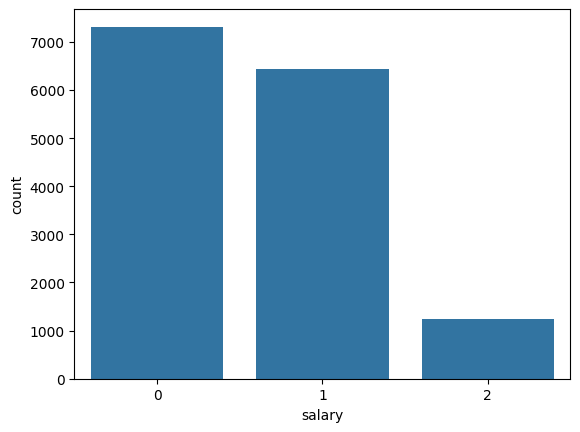

(10499, 9) (4500, 9) (10499,) (4500,)


In [ ]:
'''
문제4) testdata/HR_comma_sep.csv 파일을 이용하여 salary를 예측하는 분류 모델을 작성한다.

* 변수 종류 *
satisfaction_level : 직무 만족도
last_evaluation : 마지막 평가점수
number_project : 진행 프로젝트 수
average_monthly_hours : 월평균 근무시간
time_spend_company : 근속년수
work_accident : 사건사고 여부(0: 없음, 1: 있음)
left : 이직 여부(0: 잔류, 1: 이직)
promotion_last_5years: 최근 5년간 승진여부(0: 승진 x, 1: 승진)
sales : 부서
salary : 임금 수준 (low, medium, high)

조건 : Randomforest 클래스로 중요 변수를 찾고, Keras 지원 딥러닝 모델을 사용하시오.
Randomforest 모델과 Keras 지원 모델을 작성한 후 분류 정확도를 비교하시오.
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
# from statsmodels.stats.outliers_influence import variance_inflation_factor

data = pd.read_csv('https://raw.githubusercontent.com/pykwon/python/refs/heads/master/testdata_utf8/HR_comma_sep.csv')
# print(data.head(3))
# data.info()
# print(data.isnull().sum())

data['sales']= data['sales'].map({
    'sales':0, 'accounting':1, 'hr':2, 'technical':3, 'support':4,
    'management':5, 'IT':6, 'product_mng':7, 'marketing':8, 'RandD':9
})

data['salary'] = data['salary'].map({'low':0, 'medium':1, 'high':2})

# feature / label
x = data.drop('salary', axis=1)
# x = pd.get_dummies(x, columns=["sales"], dtype=float)
# print(x[:3])

y = data['salary']
# print(y[:3])
# le = LabelEncoder()
# y = le.fit_transform(y)
# print(y[:3])

# 종속변수 분포 확인
sns.countplot(x='salary', data=data)
plt.show()

# train / test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=23, stratify=y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape,)
# (10499, 18) (4500, 18) (10499,) (4500,)


In [15]:
rfmodel = RandomForestClassifier(random_state=42)
rfmodel.fit(x_train, y_train)

y_pred = rfmodel.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print('regression features_importance rank')
importance = rfmodel.feature_importances_
indices = np.argsort(importance)[::-1] # 내림차순

ranking = pd.DataFrame({
    'Feature':x.columns[indices],
    'Importance':importance[indices]
})
print(ranking)


Accuracy: 0.6171111111111112
regression features_importance rank
                 Feature  Importance
0   average_montly_hours    0.277351
1        last_evaluation    0.227167
2     satisfaction_level    0.226075
3                  sales    0.105365
4     time_spend_company    0.068562
5         number_project    0.058171
6          Work_accident    0.021929
7                   left    0.009157
8  promotion_last_5years    0.006222


In [29]:
# data 준비
# average_montly_hours, satisfaction_level, last_evaluation,sales
# feature = data[['average_montly_hours', 'satisfaction_level', 'last_evaluation','sales']]
# label = data['salary']
feature = data[['average_montly_hours', 'satisfaction_level', 'last_evaluation','sales']]
label = data['salary']

x_train, x_test, y_train, y_test = train_test_split(feature,label, test_size=0.3, random_state=11, stratify=label)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape,)

rfmodel = RandomForestClassifier(n_estimators=200 ,random_state=11)
rfmodel.fit(x_train, y_train)

y_pred = rfmodel.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print('regression features_importance rank')
importance = rfmodel.feature_importances_
indices = np.argsort(importance)[::-1] # 내림차순

ranking = pd.DataFrame({
    'Feature':x.columns[indices],
    'Importance':importance[indices]
})
print(ranking)

(10499, 4) (4500, 4) (10499,) (4500,)
Accuracy: 0.5924444444444444
regression features_importance rank
                Feature  Importance
0    satisfaction_level    0.348554
1        number_project    0.266469
2       last_evaluation    0.265215
3  average_montly_hours    0.119763


In [32]:
# 모델
inputs = Input(shape=(4,))
net = Dense(32, activation='elu')(inputs)
net = BatchNormalization()(net)
net = Dense(16, activation='elu')(net)
net = BatchNormalization()(net)
outputs = Dense(1, activation='softmax')(net)

model = Model(inputs, outputs)
# model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 조기종료
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=500, batch_size=64, verbose=2, validation_split=0.2 ,callbacks=[early_stopping])

# 평가
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'최종 평가 : loss={loss:.4f}, accuracy={acc*100:.4f}%')

Epoch 1/500


/Users/bunny/miniconda3/envs/tf-mac-metal/lib/python3.11/site-packages/keras/src/ops/nn.py:938: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/Users/bunny/miniconda3/envs/tf-mac-metal/lib/python3.11/site-packages/keras/src/ops/nn.py:938: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


132/132 - 4s - 33ms/step - accuracy: 0.4284 - loss: 0.0000e+00 - val_accuracy: 0.4352 - val_loss: 0.0000e+00
Epoch 2/500
132/132 - 2s - 15ms/step - accuracy: 0.4284 - loss: 0.0000e+00 - val_accuracy: 0.4352 - val_loss: 0.0000e+00
Epoch 3/500
132/132 - 2s - 15ms/step - accuracy: 0.4284 - loss: 0.0000e+00 - val_accuracy: 0.4352 - val_loss: 0.0000e+00
Epoch 4/500


KeyboardInterrupt: 

KeyError: 'val_loss'

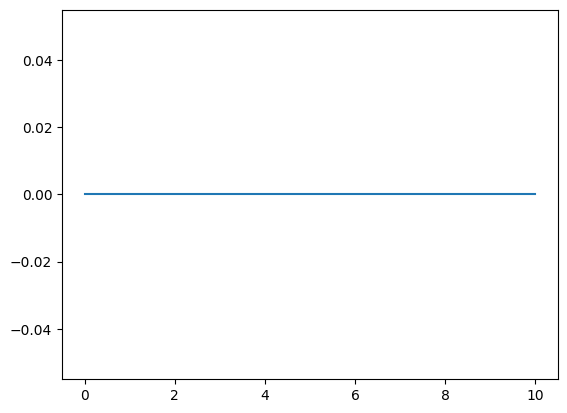

In [31]:
# 시각화 loss, acc
# 학습 곡선 시각화
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'],'r--', label='train val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.clf()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'],'r--', label='train val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()
plt.close()

n_features = feature.shape[1]
plt.barh(range(n_features), rfmodel.feature_importances_, align='center')
plt.xlabel('feature_importance')
plt.ylabel('features')
plt.yticks(np.arange(n_features), feature.columns)
plt.ylim(-1, n_features)
plt.show()
plt.close()